In [8]:
%config Completer.use_jedi = False
import numpy as np
import glob
import pandas as pd
import seaborn as sn
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, LSTM
from tensorflow.keras.layers import Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from IntegratedGradients import integrated_gradients
import matplotlib

# format figures
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['legend.title_fontsize'] = 16
matplotlib.rcParams['legend.fontsize'] = 16
matplotlib.rcParams['axes.axisbelow'] = True
matplotlib.rcParams['figure.figsize'] = [8, 6]

### Load data function

In [2]:
"""
Sewant codes
Adapted from https://medium.com/@mrunal68/tennessee-eastman-process-simulation-data-for-anomaly-detection-evaluation-d719dc133a7f
"""
def load_swant_data(size=60, shuffle=False):
    tr = pd.read_csv("../data/tr.csv")
    cv = pd.read_csv("../data/cv.csv")
    ts = pd.read_csv("../data/ts.csv")
    scalar = StandardScaler()
    # Transforming the train, test and cv data, to get an array of shape (size,52)
    tr_ = tr.values
    ts_ = ts.values
    cv_ = cv.values

    dall = np.concatenate((tr_, ts_, cv_), axis=0)
    scalar.fit(dall)
    tr_ = scalar.transform(tr_)
    tr_shape = int(tr_.shape[0] / size)
    tr_arr = np.empty([tr_shape, size, 52])
    ts_ = scalar.transform(ts_)
    ts_shape = int(ts_.shape[0] / size)
    ts_arr = np.empty([ts_shape, size, 52])
    cv_ = scalar.transform(cv_)
    cv_shape = int(cv_.shape[0] / size)
    cv_r = np.empty([cv_shape, size, 52])

    for x in range(tr_shape):
        temp = tr_[size * x: size + size * x, 4:]
        if shuffle:
            np.random.seed(0)
            temp = np.transpose(temp)
            np.random.shuffle(temp)
            temp = np.transpose(temp)
        tr_arr[x] = temp

    for x in range(ts_shape):
        temp = ts_[size * x: size + size * x, 4:]
        if shuffle:
            np.random.seed(0)
            temp = np.transpose(temp)
            np.random.shuffle(temp)
            temp = np.transpose(temp)
        ts_arr[x] = temp

    for x in range(cv_shape):
        temp = cv_[size * x: size + size * x, 4:]
        if shuffle:
            np.random.seed(0)
            temp = np.transpose(temp)
            np.random.shuffle(temp)
            temp = np.transpose(temp)
        cv_r[x] = temp

    # Transformig the class labels of train, test and cv. Every sizeth point is sampled.
    label_train = []
    for row in range(tr_shape):
        label_train.append(tr['faultNumber'][row * size] - 1)
    label_test = []
    for row in range(ts_shape):
        label_test.append(ts['faultNumber'][row * size] - 1)

    label_cv = []
    for row in range(cv_shape):
        label_cv.append(cv['faultNumber'][row * size] - 1)

    y_train = to_categorical(label_train, num_classes=20)
    y_test = to_categorical(label_test, num_classes=20)
    y_cv = to_categorical(label_cv, num_classes=20)

    x_train = np.transpose(tr_arr, (0, 2, 1))[..., np.newaxis]
    x_test = np.transpose(ts_arr, (0, 2, 1))[..., np.newaxis]
    x_cv = np.transpose(cv_r, (0, 2, 1))[..., np.newaxis]

    np.random.seed(0)
    np.random.shuffle(x_train)
    np.random.seed(0)
    np.random.shuffle(y_train)
    np.random.seed(0)
    np.random.shuffle(x_cv)
    np.random.seed(0)
    np.random.shuffle(y_cv)
    np.random.seed(0)
    np.random.shuffle(x_test)
    np.random.seed(0)
    np.random.shuffle(y_test)

    print('Data loaded...')
    return x_train, y_train, x_cv, y_cv, x_test, y_test

### Define 2D CNN model

In [3]:
def cnn(size=60, n_filters=32, n_dense=32):
    input = Input(shape=(52, size, 1))
    x = Conv2D(n_filters, 3, activation='relu')(input)
    x = MaxPool2D()(x)
    x = Conv2D(n_filters, 3, activation='relu')(x)
    x = MaxPool2D()(x)
    x = Flatten()(x)
    x = Dense(2 * n_dense, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(n_dense, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    x = Dense(20, activation='softmax')(x)
    model = Model(inputs=input, outputs=x)
    return model

### Load data

In [4]:
x_train, y_train, x_cv, y_cv, x_test, y_test = load_swant_data(size=60, shuffle=False)

Data loaded...


### Visualize data

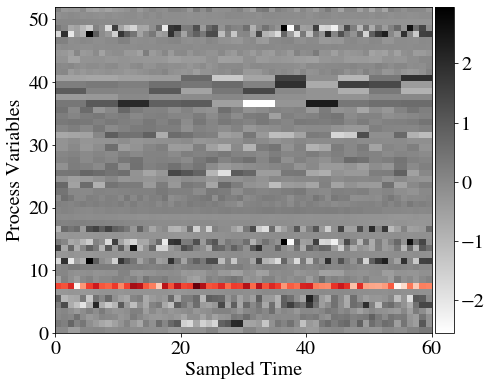

In [5]:
x_train2 = np.squeeze(x_train[0])
y_train2 = np.argmax(y_train[0])
mask = np.zeros_like(x_train2)
mask[7, :] = x_train2[7, :] - 100
masked = np.ma.masked_where(mask > -10, mask)

fig, ax = plt.subplots()
im = ax.imshow(x_train2, origin='lower', cmap="gray_r")
im2 = ax.imshow(masked, origin='lower', cmap="Reds_r")
ax.set_aspect('equal', 'box')
ax.set_xlabel('Sampled Time')
ax.set_ylabel('Process Variables')
plt.xticks([-0.5, 19.5, 39.5, 59.5], [0, 20, 40, 60])
plt.yticks([-0.5, 9.5, 19.5, 29.5, 39.5, 49.5], [0, 10, 20, 30, 40, 50])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

### Training CNN

In [9]:
model = cnn(size=60, n_filters=64, n_dense=64)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
checkpoint = ModelCheckpoint("../weight/eastman.h5", monitor='val_loss', verbose=0, save_best_only=True, mode='min')
# model.fit(x_train, y_train, batch_size=1000, epochs=500, verbose=0, callbacks=[checkpoint], validation_data=(x_val, y_val)) # uncomment to train
model.load_weights("../weight/eastman.h5")

# predict test set
y_pred = model.predict(x_test)
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)
acc = f1_score(y_true=y_true, y_pred=y_pred, average='weighted')
conf = confusion_matrix(y_true=y_true, y_pred=y_pred, normalize="true")

### Confusion matrix and accuracy

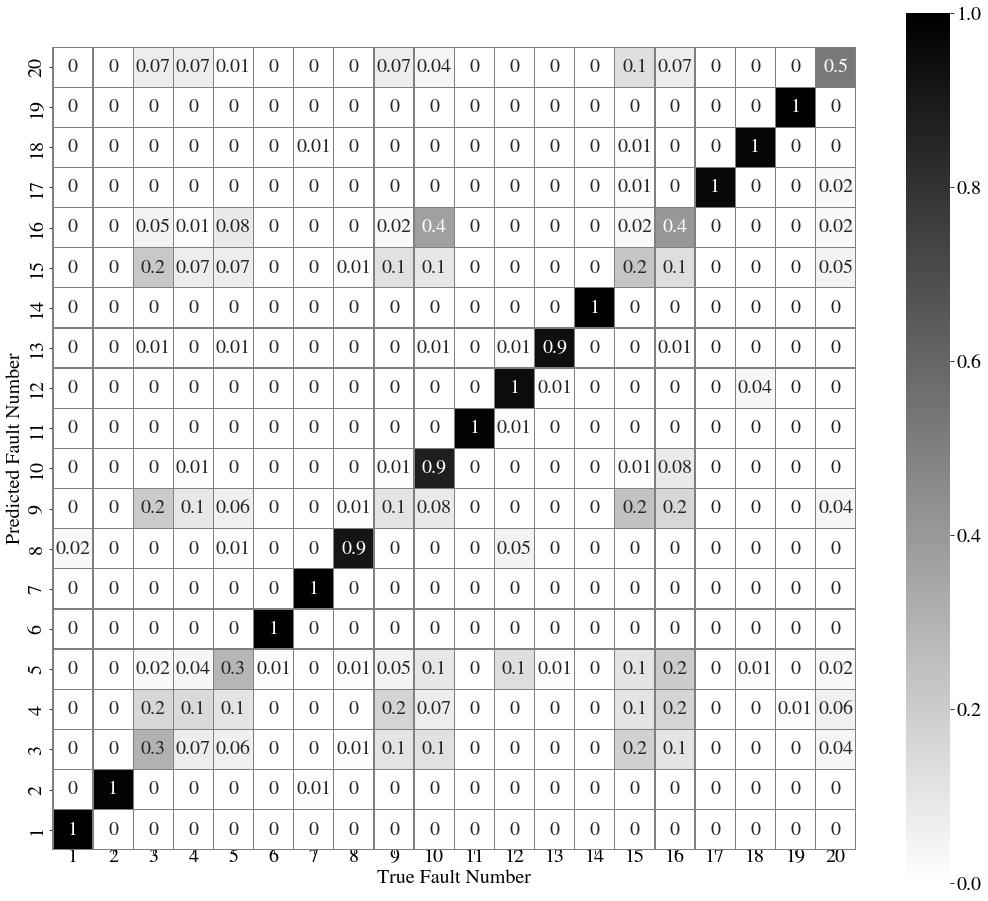

In [10]:
fault_id = [i for i in range(1, 21)]
df_cm = pd.DataFrame(conf)
plt.figure(figsize=(18, 16))
sn.heatmap(df_cm, annot=True, cmap="gray_r", 
           square=True, vmax=1, vmin=0, fmt='0.1g', linewidths=0.25, linecolor='tab:gray')
plt.xticks([i+0.5 for i in range(20)], [i+1 for i in range(20)], va='center')
plt.yticks([i+0.5 for i in range(20)], [i+1 for i in range(20)], va='center')
plt.xlim([-0.01, 20.01])
plt.ylim([-0.01, 20.01])
plt.xlabel('True Fault Number')
plt.ylabel('Predicted Fault Number')
plt.show()

In [11]:
print(f"f1-score: {acc: 0.4f}")

f1-score:  0.7177


### Saliency map using Integrated Gradients

In [12]:
ig = integrated_gradients(model)
ref = np.zeros((52, 60, 1))

x = x_test[0]
y = y_true[0]
grad = ig.explain(x, reference=ref, outc=y)
x = np.squeeze(x)
grad = np.squeeze(np.abs(grad))

Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.


### Plot input and saliency map

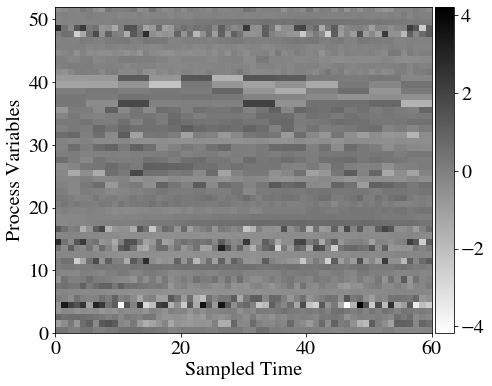

In [13]:
# input
fig, ax = plt.subplots()
im = ax.imshow(x, origin='lower', cmap="gray_r")
ax.set_aspect('equal', 'box')
ax.set_xlabel('Sampled Time')
ax.set_ylabel('Process Variables')
plt.xticks([-0.5, 19.5, 39.5, 59.5], [0, 20, 40, 60])
plt.yticks([-0.5, 9.5, 19.5, 29.5, 39.5, 49.5], [0, 10, 20, 30, 40, 50])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

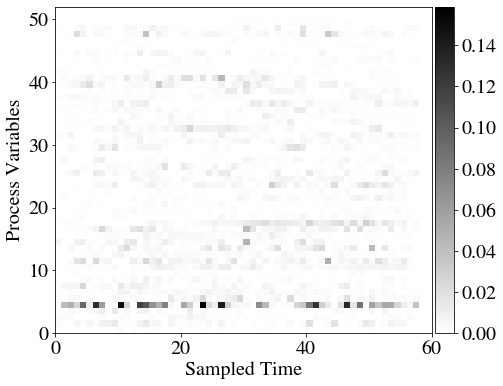

In [14]:
# saliency
fig, ax = plt.subplots()
im = ax.imshow(grad, origin='lower', cmap="gray_r")
ax.set_aspect('equal', 'box')
ax.set_xlabel('Sampled Time')
ax.set_ylabel('Process Variables')
plt.xticks([-0.5, 19.5, 39.5, 59.5], [0, 20, 40, 60])
plt.yticks([-0.5, 9.5, 19.5, 29.5, 39.5, 49.5], [0, 10, 20, 30, 40, 50])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

### Variable saliency

In [15]:
faults = ['Fault 1 A/C feed ratio, B composition constant (stream 4) Step',
          'Fault 2 B composition, A/C ratio constant (stream 4) Step',
          'Fault 3 D feed temperature (stream 2) Step',
          'Fault 4 Reactor cooling water inlet temperature Step',
          'Fault 5 Condenser cooling water inlet temperature Step',
          'Fault 6 A feed loss (stream 1) Step',
          'Fault 7 C header pressure loss - reduced availability (stream 4) Step',
          'Fault 8 A, B, C feed composition (stream 4) Random variation',
          'Fault 9 D feed temperature (stream 2) Random variation',
          'Fault 10 C feed temperature (stream 4) Random variation',
          'Fault 11 Reactor cooling water inlet temperature Random variation',
          'Fault 12 Condenser cooling water inlet temperature Random variation',
          'Fault 13 Reaction kinetics Slow drift',
          'Fault 14 Reactor cooling water valve Sticking',
          'Fault 15 Condenser cooling water valve Sticking',
          'Fault 16 Unknown',
          'Fault 17 Unknown',
          'Fault 18 Unknown',
          'Fault 19 Unknown',
          'Fault 20 Unknown']

variables = ['A Feed (Stream 1)',
'D Feed (Stream 2)',
'E Feed (Stream 3)',
'Total Feed (Stream 4)',
'Recycle Flow (Stream 8)',
'Reactor Feed Rate (Stream 6)',
'Reactor Pressure',
'Reactor Level',
'Reactor Temperature',
'Purge Rate (Stream 9)',
'Product Sep Temp',
'Product Sep Level',
'Prod Sep Pressure',
'Prod Sep Underflow (Stream 10)',
'Stripper Level'
'Stripper Pressure',
'Stripper Underflow (Stream 11)',
'Stripper Temperature',
'Stripper Steam Flow',
'Compressor Work',
'Reactor Cooling Water Outlet Temp',
'Separator Cooling Water Outlet Temp',
'Component A (Stream 6)',
'Component B (Stream 6)',
'Component C (Stream 6)',
'Component D (Stream 6)',
'Component E (Stream 6)',
'Component F (Stream 6)',
'Component A (Stream 9)',
'Component B (Stream 9)',
'Component C (Stream 9)',
'Component D (Stream 9)',
'Component E (Stream 9)',
'Component F (Stream 9)',
'Component G (Stream 9)',
'Component H (Stream 9)',
'Component D (Stream 11)',
'Component E (Stream 11)',
'Component F (Stream 11)',
'Component G (Stream 11)',
'Component H (Stream 11)',
'D Feed Flow (Stream 2)',
'E Feed Flow (Stream 3)',
'A Feed Flow (Stream 1)',
'Total Feed Flow (Stream 4)',
'Compressor Recycle Valve',
'Purge Valve (Stream 9)',
'Separator Pot Liquid Flow (Stream 10)',
'Stripper Liquid Product Flow (Stream 11)',
'Stripper Steam Valve',
'Reactor Cooling Water Flow',
'Condenser Cooling Water Flow',
'AgitatorSpeed']

### Function to calculate most important variables for a given fault

In [16]:
def variable_importance(var):
    indices = np.where(y_true==var)[0]
    grad_all = []
    for i in range(len(indices)):
        index = indices[i]
        grad = ig.explain(x_test[index], reference=ref, outc=y_true[index])
        grad = np.squeeze(np.abs(grad))
        grad = np.mean(grad, axis=-1)
        grad_all.append(grad / np.sum(grad))
        
    grad_all = np.array(grad_all)
    grad_avg = np.mean(grad_all, axis=0)
    grad_avg = grad_avg / np.sum(grad_avg)
    max_idx = grad_avg.argsort()[-5:][::-1]
    return grad_all

Fault 14 Reactor cooling water valve Sticking


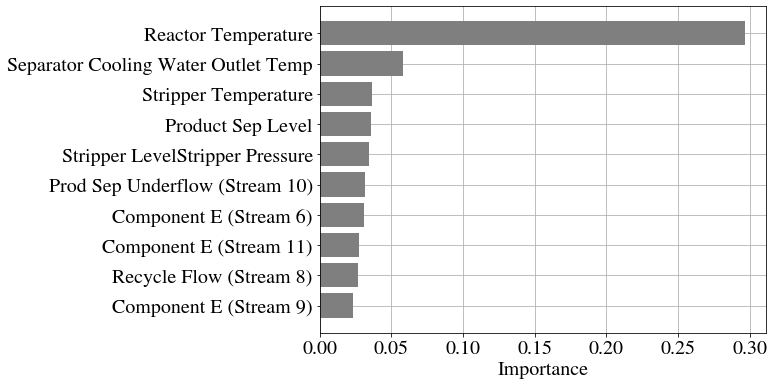

In [18]:
grad = variable_importance(13) # The 13th fault
print(faults[13])
im = grad.mean(axis=0)
im = im / sum(im)
max_idx = im.argsort()[-10:][::-1]

plt.figure()
plt.barh([10-i for i in range(10)], im[max_idx], color='tab:grey')
plt.yticks([10-i for i in range(10)], 
           [variables[i] for i in max_idx])
plt.xlabel('Importance')
plt.grid()
plt.show()